## 1. Setup and Data Loading

In [1]:
%pip install matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries imported successfully!")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp314-cp314-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp314-cp314-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached numpy-2.3.5-cp314-cp314-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached pandas-2.3.3-cp314-cp314-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached scipy-1.16.3-cp314-cp314-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.5 MB/s  0:00:007.4 MB/s eta 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 29.8 MB/s  0:00:00 31.2 MB/s eta 0:00:01
Using cached contourpy-1

In [2]:
# Load preprocessed data
df = pd.read_csv('../data/preprocessed_final.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
df.head()

Dataset loaded: (1785, 68)
Date range: 1996-06-13 to 2020-02-27


,date,next_trading_day,speaker,Positive,Negative,Polarity,LM_pos_rate,LM_neg_rate,LM_net_polarity_per_token,fomc_hawk,...,target_NDQ_1d,target_NDQ_5d,class_SP500_1d,class_SP500_5d,class_RSL_1d,class_RSL_5d,class_DJIA_1d,class_DJIA_5d,class_NDQ_1d,class_NDQ_5d
0,1996-12-19,1996-12-20,Vice Chair Alice M. Rivlin,50,88,-0.275362,0.029638,0.052164,-0.022525,0.000294,...,-0.003616,0.009195,Neutral,Neutral,Neutral,Neutral,Bearish,Neutral,Neutral,Neutral
1,1996-12-06,1996-12-09,Chairman Alan Greenspan,59,70,-0.085271,0.046975,0.055732,-0.008758,0.099280,...,0.002247,-0.027768,Neutral,Bearish,Neutral,Bearish,Bearish,Bearish,Neutral,Bearish
2,1996-12-05,1996-12-06,Chairman Alan Greenspan,62,137,-0.376884,0.033550,0.074134,-0.040584,0.002163,...,0.014037,-0.003713,Bullish,Bearish,Bullish,Bearish,Bullish,Neutral,Bullish,Neutral
3,1996-12-03,1996-12-04,"Governor Edward W. Kelley, Jr.",36,59,-0.242105,0.028916,0.047390,-0.018474,0.000181,...,0.002653,-0.001117,Neutral,Neutral,Neutral,Neutral,Neutral,Bullish,Neutral,Neutral
4,1996-11-25,1996-11-26,Governor Susan M. Phillips,52,32,0.238095,0.047575,0.029277,0.018298,0.000161,...,0.003671,0.019125,Neutral,Bearish,Neutral,Bearish,Neutral,Neutral,Neutral,Bullish


In [3]:
df.columns

Index(['date', 'next_trading_day', 'speaker', 'Positive', 'Negative',
       'Polarity', 'LM_pos_rate', 'LM_neg_rate', 'LM_net_polarity_per_token',
       'fomc_hawk', 'fomc_dove', 'fomc_neutral', 'finbert_score',
       'topic_confidence', 'topic_prob_6', 'topic_prob_0', 'topic_prob_1',
       'topic_prob_4', 'topic_prob_3', 'topic_prob_2', 'topic_prob_5',
       'topic_prob_14', 'topic_prob_15', 'topic_prob_10', 'SP500_ret_1d',
       'SP500_ret_5d', 'SP500_ret_20d', 'SP500_vol_20d', 'RSL_ret_1d',
       'RSL_ret_5d', 'RSL_ret_20d', 'RSL_vol_20d', 'DJIA_ret_1d',
       'DJIA_ret_5d', 'DJIA_ret_20d', 'DJIA_vol_20d', 'NDQ_ret_1d',
       'NDQ_ret_5d', 'NDQ_ret_20d', 'NDQ_vol_20d', 'unemployment',
       'fed interest rate', 'day_of_week', 'month', 'year', 'pre_crisis',
       'crisis', 'post_crisis', 'is_chair', 'is_vice_chair', 'n_tokens',
       'finbert_label_encoded', 'target_SP500_1d', 'target_SP500_5d',
       'target_RSL_1d', 'target_RSL_5d', 'target_DJIA_1d', 'target_DJIA_5d',


## 2. Prepare Features and Target

In [4]:
# Define columns
fin_price_cols = [
    'SP500_ret_1d',
       'SP500_ret_5d', 'SP500_ret_20d', 'SP500_vol_20d', 'RSL_ret_1d',
       'RSL_ret_5d', 'RSL_ret_20d', 'RSL_vol_20d', 'DJIA_ret_1d',
       'DJIA_ret_5d', 'DJIA_ret_20d', 'DJIA_vol_20d', 'NDQ_ret_1d',
       'NDQ_ret_5d', 'NDQ_ret_20d', 'NDQ_vol_20d'
]

metadata_cols = ['date', 'next_trading_day', 'speaker']
target_cols = [c for c in df.columns if c.startswith('target_') or c.startswith('class_')]
feature_cols = [c for c in df.columns if c not in metadata_cols + target_cols + fin_price_cols]

print(f"Features: {len(feature_cols)}")
print(f"Targets: {len(target_cols)}")

Features: 33
Targets: 16


In [5]:
# Primary target: S&P 500 next-day classification
primary_target = 'class_SP500_1d'

X = df[feature_cols].copy()
y = df[primary_target].copy()

# Encode target labels
label_mapping = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}
y_encoded = y.map(label_mapping)

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")


Target distribution:
class_SP500_1d
Neutral    911
Bullish    491
Bearish    383
Name: count, dtype: int64

Features shape: (1785, 33)
Target shape: (1785,)


In [6]:
# 🔄 OVERRIDE: Switch to 5-day target for better predictability
primary_target = 'class_SP500_5d'
y = df[primary_target].copy()
y_encoded = y.map(label_mapping)

print(f"\n📊 NEW TARGET: {primary_target}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Percentage distribution:")
print(y.value_counts(normalize=True).round(3))
print(f"\nTarget shape: {y_encoded.shape}")


📊 NEW TARGET: class_SP500_5d
Target distribution:
class_SP500_5d
Neutral    829
Bullish    562
Bearish    394
Name: count, dtype: int64
Percentage distribution:
class_SP500_5d
Neutral    0.464
Bullish    0.315
Bearish    0.221
Name: proportion, dtype: float64

Target shape: (1785,)


## 2.5. Alternative Target: Binary "Large Movement" Prediction

In [7]:
# Create binary target: Does speech cause significant movement?
# Hypothesis: Fed speeches matter when they cause LARGE moves, not just direction

# Use 1% threshold for "large" movement
threshold = 0.01

# Create binary target from raw returns (1d)
df['large_move_1d'] = (df['target_SP500_1d'].abs() > threshold).astype(int)

# Also for 5d
df['large_move_5d'] = (df['target_SP500_5d'].abs() > threshold).astype(int)

print("📊 BINARY TARGET: Large Movement Detection")
print(f"\n1-Day Large Movements (>{threshold*100}%):")
print(df['large_move_1d'].value_counts())
print(f"Percentage: {df['large_move_1d'].value_counts(normalize=True).round(3)}")

print(f"\n5-Day Large Movements (>{threshold*100}%):")
print(df['large_move_5d'].value_counts())
print(f"Percentage: {df['large_move_5d'].value_counts(normalize=True).round(3)}")

📊 BINARY TARGET: Large Movement Detection

1-Day Large Movements (>1.0%):
large_move_1d
0    1311
1     474
Name: count, dtype: int64
Percentage: large_move_1d
0    0.734
1    0.266
Name: proportion, dtype: float64

5-Day Large Movements (>1.0%):
large_move_5d
1    1045
0     740
Name: count, dtype: int64
Percentage: large_move_5d
1    0.585
0    0.415
Name: proportion, dtype: float64


In [8]:
primary_target = 'large_move_1d'
y = df[primary_target].copy()
y_encoded = y  # Already 0/1, no mapping needed

label_mapping_binary = {0: 'Small Move', 1: 'Large Move'}

print(f"\nACTIVE TARGET: {primary_target}")
print(f"Target distribution:")
print(f"  Small moves (<1%): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Large moves (>1%): {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"\nTarget shape: {y_encoded.shape}")


ACTIVE TARGET: large_move_1d
Target distribution:
  Small moves (<1%): 1311 (73.4%)
  Large moves (>1%): 474 (26.6%)

Target shape: (1785,)


## 3. Train-Test Split (Time-Based)

In [9]:
# 80/20 split, preserving temporal order
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded.iloc[:split_index]
y_test = y_encoded.iloc[split_index:]

train_dates = df['date'].iloc[:split_index]
test_dates = df['date'].iloc[split_index:]

print(f"Training: {len(X_train)} samples ({train_dates.min().date()} to {train_dates.max().date()})")
print(f"Testing: {len(X_test)} samples ({test_dates.min().date()} to {test_dates.max().date()})")
print(f"\nTraining class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest class distribution:\n{y_test.value_counts().sort_index()}")

Training: 1428 samples (1996-06-13 to 2013-12-16)
Testing: 357 samples (2013-01-04 to 2020-02-27)

Training class distribution:
large_move_1d
0    1021
1     407
Name: count, dtype: int64

Test class distribution:
large_move_1d
0    290
1     67
Name: count, dtype: int64


## 4. Baseline Model

In [10]:
# Baseline: Always predict most common class
most_common_class = y_train.mode()[0]
baseline_pred = np.full(len(y_test), most_common_class)
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline: Always predict class {most_common_class}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")


Baseline: Always predict class 0
Baseline Accuracy: 0.8123


## 5. Train SVM

In [11]:
svm_model = SVC(
    kernel="linear",
    class_weight="balanced",
    gamma="scale",
    probability=True
)

print("Training SVM")
svm_model.fit(X_train, y_train)


Training SVM


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


## 6. Evaluate Performance

In [12]:
# Make predictions
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("="*60)
print("SVM RESULTS")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"\nBaseline:  {baseline_acc:.4f}")
print(f"Improvement: {(acc - baseline_acc)*100:.2f}%")
print("="*60)

SVM RESULTS
Accuracy:  0.7899
Precision: 0.7483
Recall:    0.7899
F1 Score:  0.7613

Baseline:  0.8123
Improvement: -2.24%


In [13]:
# Detailed classification report (binary)
print("\nDetailed Classification Report:")
if len(np.unique(y_test)) == 2:
    # Binary classification
    print(classification_report(y_test, y_pred, target_names=['Small Move', 'Large Move'], zero_division=0))
else:
    # Multi-class
    print(classification_report(y_test, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'], zero_division=0))


Detailed Classification Report:
              precision    recall  f1-score   support

  Small Move       0.83      0.93      0.88       290
  Large Move       0.38      0.19      0.26        67

    accuracy                           0.79       357
   macro avg       0.61      0.56      0.57       357
weighted avg       0.75      0.79      0.76       357



In [16]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral/Bearish', 'Bullish'], zero_division=0))


Detailed Classification Report:
                 precision    recall  f1-score   support

Neutral/Bearish       0.83      0.93      0.88       290
        Bullish       0.38      0.19      0.26        67

       accuracy                           0.79       357
      macro avg       0.61      0.56      0.57       357
   weighted avg       0.75      0.79      0.76       357



## 7. Confusion Matrix

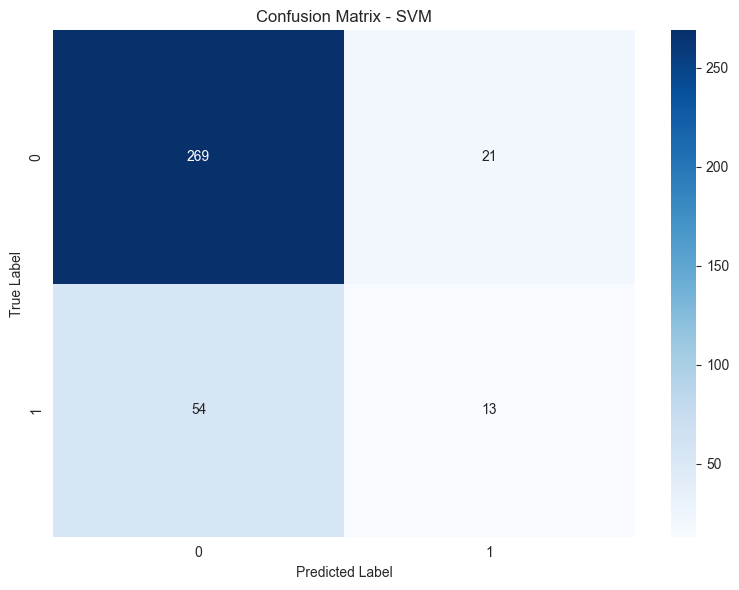

Confusion Matrix:
[[269  21]
 [ 54  13]]


In [19]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)

## 8. Feature Importance

In [20]:
# Get feature "importance" from linear SVM coefficients
# For multi-class, average absolute coefficients across the one-vs-one classifiers
coef = svm_model.coef_          # shape: (n_class_pairs, n_features)
importance = np.mean(np.abs(coef), axis=0)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
          feature  importance
     topic_prob_6    7.061066
       pre_crisis    5.867933
     topic_prob_2    4.614785
           crisis    4.606228
     topic_prob_3    4.598519
    finbert_score    3.484361
         is_chair    2.172130
     topic_prob_4    2.165568
     topic_prob_0    1.910436
     topic_prob_5    1.754818
      day_of_week    1.441997
    topic_prob_15    1.388099
    is_vice_chair    1.333269
      post_crisis    1.261705
fed interest rate    1.119976
             year    1.050987
 topic_confidence    0.864417
        fomc_hawk    0.801460
         Polarity    0.790008
     unemployment    0.727057


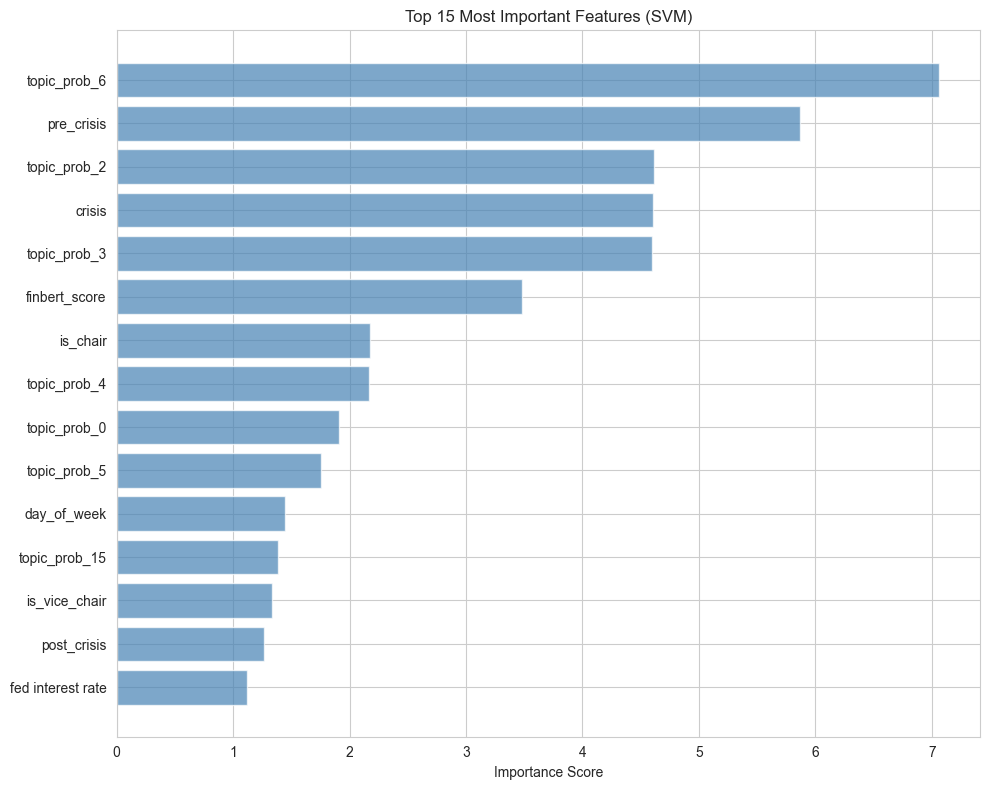

In [21]:
# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features (SVM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Feature Importance by Category


Feature Importance by Category:
category
Topics       25.922696
Temporal     14.366208
Sentiment     6.379038
Speaker       3.507178
Macro         1.847033
Other         0.194640
Name: importance, dtype: float64


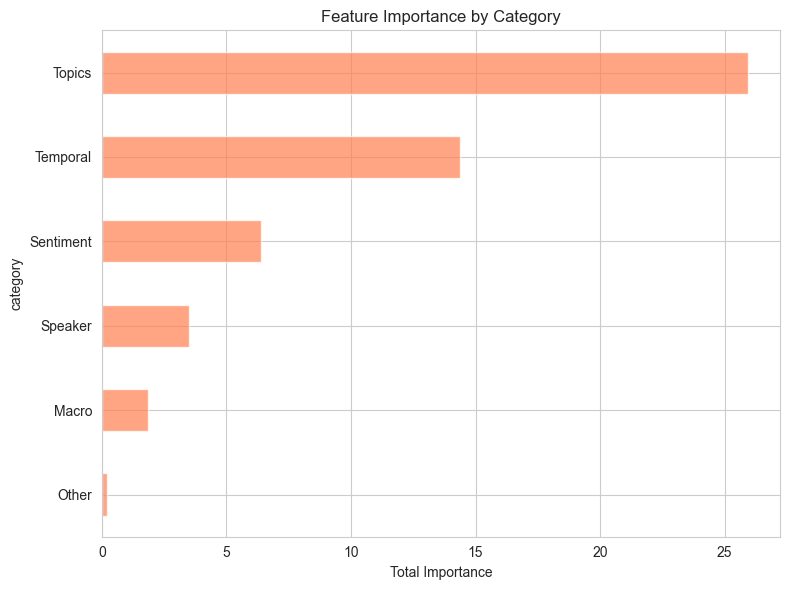

In [22]:
# Categorize features
def categorize_feature(feat):
    if any(x in feat.lower() for x in ['positive', 'negative', 'polarity', 'sentiment', 'hawk', 'dove', 'finbert', 'lm_']):
        return 'Sentiment'
    elif 'topic' in feat.lower():
        return 'Topics'
    elif any(x in feat.lower() for x in ['ret_', 'vol_']):
        return 'Market Context'
    elif any(x in feat.lower() for x in ['unemployment', 'interest']):
        return 'Macro'
    elif any(x in feat.lower() for x in ['year', 'month', 'day', 'crisis']):
        return 'Temporal'
    elif any(x in feat.lower() for x in ['chair', 'tokens']):
        return 'Speaker'
    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)

# Aggregate by category
category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)

print("\nFeature Importance by Category:")
print(category_importance)

# Plot
plt.figure(figsize=(8, 6))
category_importance.plot(kind='barh', color='coral', alpha=0.7)
plt.xlabel('Total Importance')
plt.title('Feature Importance by Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Time Series Cross-Validation

In [ ]:
# Perform 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print("Performing Time Series Cross-Validation...\n")

cv_scores = []
fold_num = 1

for train_idx, val_idx in tscv.split(X):
    X_train_cv = X.iloc[train_idx]
    X_val_cv   = X.iloc[val_idx]
    y_train_cv = y_encoded.iloc[train_idx]
    y_val_cv   = y_encoded.iloc[val_idx]
    
    # Train model
    svm_cv = SVC(
        kernel="linear",
        class_weight="balanced",
        gamma="scale"
    )
    svm_cv.fit(X_train_cv, y_train_cv)
    
    # Evaluate
    y_pred_cv = svm_cv.predict(X_val_cv)
    acc_cv = accuracy_score(y_val_cv, y_pred_cv)
    f1_cv  = f1_score(y_val_cv, y_pred_cv, average='weighted', zero_division=0)
    
    cv_scores.append({'fold': fold_num, 'accuracy': acc_cv, 'f1': f1_cv})
    print(f"Fold {fold_num}: Accuracy = {acc_cv:.4f}, F1 = {f1_cv:.4f}")
    fold_num += 1

cv_df = pd.DataFrame(cv_scores)
print(f"\n{'='*60}")
print("Cross-Validation Summary:")
print(f"Mean Accuracy: {cv_df['accuracy'].mean():.4f} (+/- {cv_df['accuracy'].std():.4f})")
print(f"Mean F1 Score: {cv_df['f1'].mean():.4f} (+/- {cv_df['f1'].std():.4f})")
print(f"{'='*60}")


Performing Time Series Cross-Validation...

Fold 1: Accuracy = 0.4242, F1 = 0.2886
Fold 2: Accuracy = 0.7071, F1 = 0.7522


## 11. Prediction Analysis

In [ ]:
# Analyze when model works best
test_analysis = df.iloc[split_index:].copy()
test_analysis['true_class'] = y_test
test_analysis['pred_class'] = y_pred
test_analysis['correct'] = (y_test == y_pred).astype(int)

print("Accuracy by Speaker Type:")
print("\nFed Chair vs Others:")
speaker_acc = test_analysis.groupby('is_chair')['correct'].agg(['mean', 'count'])
speaker_acc.index = ['Other Officials', 'Fed Chair']
print(speaker_acc)

print("\nAccuracy by Time Period:")
period_mapping = {1: 'Pre-Crisis', 0: 'Other'}
if 'crisis' in test_analysis.columns:
    test_analysis['period'] = test_analysis.apply(
        lambda x: 'Crisis' if x['crisis'] == 1 else ('Pre-Crisis' if x['pre_crisis'] == 1 else 'Post-Crisis'),
        axis=1
    )
    print(test_analysis.groupby('period')['correct'].agg(['mean', 'count']))

## 12. Save Results

In [ ]:
# Save predictions
test_results = df.iloc[split_index:].copy()
test_results['true_class'] = y_test
test_results['predicted_class'] = y_pred
test_results['correct'] = (y_test == y_pred).astype(int)

# Add probability scores
test_results['prob_bearish'] = y_pred_proba[:, 0]
test_results['prob_neutral'] = y_pred_proba[:, 1]
test_results['prob_bullish'] = y_pred_proba[:, 2]

predictions_df = test_results[[
    'date', 'speaker', 'true_class', 'predicted_class', 'correct',
    'prob_bearish', 'prob_neutral', 'prob_bullish'
]]
predictions_df.to_csv('svm_predictions.csv', index=False)
print("✅ Predictions saved: svm_predictions.csv")

# Save feature importance
importance_df.to_csv('svm_feature_importance.csv', index=False)
print("✅ Feature importance saved: svm_feature_importance.csv")

# Save model
import pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("✅ Model saved: svm_model.pkl")

## 13. Summary

In [ ]:
print("="*80)
print("SVM - FINAL SUMMARY")
print("="*80)
print(f"\n📊 Model: SVM (SVC, kernel={svm_model.kernel})")
print(f"🎯 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)")
print(f"\n📈 Performance:")
print(f"  - Test Accuracy: {acc:.4f}")
print(f"  - Baseline: {baseline_acc:.4f}")
print(f"  - Improvement: {(acc - baseline_acc)*100:.2f}%")
print(f"  - F1 Score: {f1:.4f}")
print(f"\n🔄 Cross-Validation:")
print(f"  - Mean Accuracy: {cv_df['accuracy'].mean():.4f}")
print(f"  - Std: {cv_df['accuracy'].std():.4f}")
print(f"\n🌟 Top 3 Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
print(f"\n📊 Feature Category Ranking:")
for cat, imp in category_importance.head(3).items():
    print(f"  - {cat}: {imp:.4f}")
print(f"\n💡 Interpretation:")
if acc > baseline_acc + 0.05:
    print("  ✅ Model shows strong predictive power!")
elif acc > baseline_acc:
    print("  ⚠️  Weak signal detected.")
else:
    print("  ❌ No improvement over baseline.")
print("\n" + "="*80)

print(f"\n📈 Performance:")
print(f"  - Test Accuracy: {acc:.4f}")
print(f"  - Baseline: {baseline_acc:.4f}")
print(f"  - Improvement: {(acc - baseline_acc)*100:.2f}%")
print(f"  - F1 Score: {f1:.4f}")
print(f"\n🔄 Cross-Validation:")
print(f"  - Mean Accuracy: {cv_df['accuracy'].mean():.4f}")
print(f"  - Std: {cv_df['accuracy'].std():.4f}")
print(f"\n🌟 Top 3 Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
print(f"\n📊 Feature Category Ranking:")
for cat, imp in category_importance.head(3).items():
    print(f"  - {cat}: {imp:.4f}")
print(f"\n💡 Interpretation:")
if acc > baseline_acc + 0.05:
    print("  ✅ Model shows strong predictive power!")
elif acc > baseline_acc:
    print("  ⚠️  Weak signal detected.")
else:
    print("  ❌ No improvement over baseline.")
print("\n" + "="*80)